In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Low_Rank_Approximation.approximate_multiplication import approx_SVD
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from itertools import pairwise

In [97]:
df = pd.read_csv("Data/blogfeedback/blogData_train.csv", header=None)
# Shuffle
test = round(.7 * df.shape[0])
y = df.iloc[:,280]
X = df.iloc[:,:280]
y_train = df.iloc[:test,280]
X_train = df.iloc[:test,:280]
y_test = df.iloc[test:,280]
X_test = df.iloc[test:, :280]

In [98]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

train_boost = round(.4 * X_train.shape[0])
X_train_boost = X_train.iloc[:train_boost,:]
y_train_boost = y_train.iloc[:train_boost]

class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(128, 32)
        self.output_layer = nn.Linear(32, 1)
    
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        return self.output_layer(x)
    
    def extract_features(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        return x

model = SimpleNN(input_size=X_train_boost.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# Train your model
import tqdm
from sklearn.metrics import r2_score
batch_size = 64

for epoch in tqdm.tqdm(range(1000)):
    # Sample a random minibatch from your dataset
    indices = np.random.choice(len(X_train_boost), batch_size, replace=False).tolist()
    inputs = torch.tensor(np.array(X_train_boost.loc[indices]), dtype=torch.float32)
    labels = torch.tensor(np.array(y_train_boost.loc[indices]), dtype=torch.float32).view(-1, 1)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

# Evaluate r2 on full dataset
print(r2_score(y_train_boost, model(torch.tensor(np.array(X_train_boost), dtype=torch.float32)).detach().numpy()))


100%|██████████| 1000/1000 [00:01<00:00, 534.34it/s]

0.5670518929473778


In [99]:
# Using deep learning model, extract the features
extracted_features = []
model.eval()
with torch.no_grad():
    inputs = torch.tensor(np.array(X_train), dtype=torch.float32)
    X_train_engineered = model.extract_features(inputs)
    inputs = torch.tensor(np.array(X_test), dtype=torch.float32)
    X_test_engineered = model.extract_features(inputs)

# Stack original features with engineered features
X_train_engineered = np.hstack([np.array(X_train), X_train_engineered.numpy()])
X_test_engineered = np.hstack([np.array(X_test), X_test_engineered.numpy()])
print(X_train_engineered.shape, X_test_engineered.shape)

(36678, 312) (15719, 312)


In [100]:
import xgboost as xgb
from sklearn.linear_model import LinearRegression

train_boost = round(.2 * X_train_engineered.shape[0])
X_train_boost = X_train_engineered[:train_boost,:]
y_train_boost = y[:train_boost]

# Step 1: Fit an XGBoost model
xgb_model = xgb.XGBRegressor(objective="reg:squarederror")
xgb_model.fit(X_train, y_train)

# Get feature importances and select the last N features
feature_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
N = 200  # Number of features to select
last_n_features = feature_importances.nsmallest(N).index.tolist()

# Step 2: Run Linear Regression with last N features
X_train_engineered = X_train_engineered[:, last_n_features]
X_test_engineered = X_test_engineered[:, last_n_features]

lr_model = LinearRegression()
lr_model.fit(X_train_engineered, y_train)
print(r2_score(y_train, lr_model.predict(X_train_engineered)))

0.3223127917410805


In [102]:
np.linalg.cond(X_train_engineered.T @ X_train_engineered)

1.2058247747517658e+24

In [103]:
# Scale our engineered features
scaler = StandardScaler()
scaled_X_train_engineered = scaler.fit_transform(X_train_engineered)
scaled_X_test_engineered = scaler.transform(X_test_engineered)

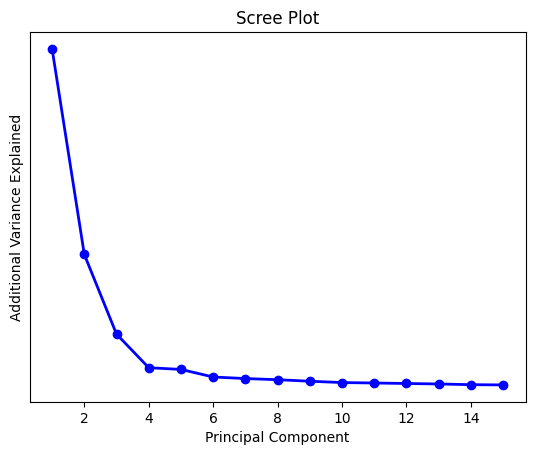

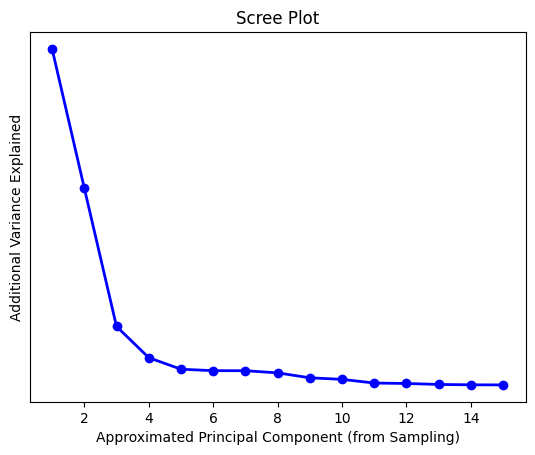

In [104]:
pca = PCA(n_components=15)
pca_fit = pca.fit(scaled_X_train_engineered)
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Additional Variance Explained')
# Remove ticks on y axis
plt.yticks([])
plt.show()

V = approx_SVD(scaled_X_train_engineered, 400)
projection = np.zeros((200, 200))
sum_variances = []
for i in range(len(V)):
    projection += np.outer(V[i], V[i])
    sum_variances.append(np.linalg.norm(scaled_X_train_engineered @ projection))

variances = [sum_variances[0]] + [y - x for x, y in pairwise(sum_variances)]
variances.sort(reverse=True)

variances /= np.linalg.norm(scaled_X_train_engineered)
plt.plot(PC_values, variances[:pca.n_components_], 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Approximated Principal Component (from Sampling)')
plt.ylabel('Additional Variance Explained')
plt.yticks([])
plt.show()

In [105]:
import numpy as np
import numba
import time
import scipy

# Helper functions for Least Squares Approximation: Random Projection and Sketching
@numba.jit(nopython=True)
def hamming_weight_array(x):
    count_array = np.zeros_like(x, dtype=np.int8)
    for index in np.ndindex(x.shape):
        count = 0
        value = x[index]
        while value:
            count += value & 1
            value >>= 1
        count_array[index] = count
    return count_array


@numba.jit(nopython=True)
def vectorized_hadamard_rows_with_D(row_indices, n):
    output_rows = np.empty((len(row_indices), n), dtype=np.int8)
    # D = 2 * np.random.randint(0, 2, size=n) - 1
    indices_j = np.arange(n)
    # Compute the Hadamard matrix rows for the given indices
    for count, i in enumerate(row_indices):
        # Compute bitwise AND for every pair i and all j indices
        binary_dot_products = np.bitwise_and(i, indices_j)
        # Compute the Hadamard matrix row entries, then multiply -1 with 0.5 probability
        output_rows[count] = hamming_weight_array(binary_dot_products) * (2 * np.random.randint(0, 2, size=1) - 1)
    return (-1) ** output_rows


# Helper functions for Least Squares Approximation: Random Sampling
def generate_random_projection(r_1, r_2):
    # Generates the randomized unstructured projection (P in our paper)
    return np.random.choice([-np.sqrt(3/r_1), np.sqrt(3/r_1), 0], size=(r_1, r_2), p=[1/6, 1/6, 2/3])


@numba.jit(nopython=True)
def sample_indices(row_indices, n):
    sampled_indices = np.zeros(n, dtype=np.int8)
    for i in range(n):
        random_value = np.random.random()
        cum_sum = 0.0
        for j, weight in enumerate(row_indices):
            cum_sum += weight
            if random_value < cum_sum:
                sampled_indices[i] = j
                break 
    return sampled_indices


def sketch_and_solve(A, b, r, direct=True, precondition_with_QR=False, **kwargs):
    """
    Parameters:
        A: matrix of size m x n
        b: vector of size m (we want to solve Ax = b)
        r: sketch size (dimension we are projecting to)
        direct: whether to use a direct solver or an iterative solver to solve the least squares problem
        precondition_with_QR: whether to precondition the least squares problem with the sketch matrix (for MINRES)
    
    Returns:
        solution to the least squares problem
    """
    m = A.shape[0]
    rand_rows = np.random.choice(m, r, replace=True)
    SH_mD = vectorized_hadamard_rows_with_D(rand_rows, m)
    # Multiply the rows by the Hadamard matrix
    if direct:
        return scipy.linalg.lstsq(SH_mD @ A, SH_mD @ b)[0]
    else:
        if precondition_with_QR:
            _, R = np.linalg.qr(SH_mD @ A)
            minres_sol = scipy.sparse.linalg.minres((SH_mD @ A).T @ (SH_mD @ A) @ R, (SH_mD @ A).T @ SH_mD @ b, **kwargs)[0]
            return np.linalg.solve(R, minres_sol)
        return scipy.sparse.linalg.minres((SH_mD @ A).T @ (SH_mD @ A), (SH_mD @ A).T @ SH_mD @ b, **kwargs)[0]


def sample_and_solve(A, b, r_1, r_2, k, direct=True, precondition_with_QR=False, **kwargs):
    """
    Parameters:
        A: matrix of size m x n
        b: vector of size m (we want to solve Ax = b)
        r_1: sketch size
        r_2: sketch size
        k: number of samples to take for our sketch
        direct: whether to use a direct solver or an iterative solver to solve the least squares problem
        precondition_with_QR: whether to precondition the least squares problem with the sketch matrix (for MINRES)
    
    Returns:
        solution to the least squares problem
    """
    m = A.shape[0]
    rand_rows = np.random.choice(m, r_1, replace=True)
    P = generate_random_projection(r_1, r_2)
    SH_mD = vectorized_hadamard_rows_with_D(rand_rows, m)
    approximate_lev = np.sum((A @ np.linalg.pinv(SH_mD @ A) @ P) ** 2, axis=1)
    approximate_lev /= np.sum(approximate_lev)
    sampled_indices = sample_indices(approximate_lev, k)
    approximate_lev *= k
    sampled_sketch_A = A[sampled_indices] * approximate_lev[sampled_indices, None]
    sampled_sketch_b = b[sampled_indices] * approximate_lev[sampled_indices]
    if direct:
        return scipy.linalg.lstsq(sampled_sketch_A, sampled_sketch_b)[0]
    else:
        if precondition_with_QR:
            _, R = np.linalg.qr(sampled_sketch_A)
            minres_sol = scipy.sparse.linalg.minres(sampled_sketch_A.T @ sampled_sketch_A @ R, sampled_sketch_A.T @ sampled_sketch_b, **kwargs)[0]
            return np.linalg.solve(R, minres_sol)
        return scipy.sparse.linalg.minres(sampled_sketch_A.T @ sampled_sketch_A, sampled_sketch_A.T @ sampled_sketch_b, **kwargs)[0]

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge

pca = PCA(n_components=10)
pca_fit = pca.fit(scaled_X_train_engineered)
X_train_pca = pca_fit.transform(np.array(scaled_X_train_engineered))
X_test_pca = pca_fit.transform(scaled_X_test_engineered)

# Add row of ones for intercept
X_train_pca_with_intercept = np.hstack((np.ones((X_train_pca.shape[0], 1)), X_train_pca))
X_test_pca_with_intercept = np.hstack((np.ones((X_test_pca.shape[0], 1)), X_test_pca))
X_train_engineered_with_intercept = np.hstack((np.ones((X_train_engineered.shape[0], 1)), X_train_engineered))
X_test_engineered_with_intercept = np.hstack((np.ones((X_test_engineered.shape[0], 1)), X_test_engineered))

beta1 = sketch_and_solve(np.array(X_train_pca_with_intercept), np.array(y_train), 5000)
print(r2_score(y_train, X_train_pca_with_intercept @ beta1))
beta2 = np.linalg.lstsq(X_train_engineered_with_intercept, y_train)[0]
print(r2_score(y_train, X_train_engineered_with_intercept @ beta2))
# beta3 = Ridge(alpha=0.25).fit(X_train, y_train).coef_

pred1 = X_test_pca_with_intercept @ beta1
pred2 = X_test_engineered_with_intercept @ beta2
# pred3 = X_test @ beta3

print(r2_score(y_test, pred1))
print(mean_squared_error(y_test, pred1))
print(r2_score(y_test, pred2))
print(mean_squared_error(y_test, pred2))
# print(mean_squared_error(y_test, pred3))